<a href="https://colab.research.google.com/github/ol287/Learning-from-data/blob/main/week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo

The first part of this file is a demo - run all of this part (and look over the code) so you can go to the interpretability section where the exercises are

#Imports

Import TensorFlow and anything else you may need

In [2]:
# Importing TensorFlow library, a popular framework for deep learning and machine learning
import tensorflow as tf

# Printing the TensorFlow version to ensure the library is correctly installed and to know which version is being used
print("TensorFlow version:", tf.__version__)

# Importing the NumPy library, which is used for numerical computations and array manipulations
import numpy as np

# Importing Matplotlib for creating visualizations such as plots and graphs
import matplotlib.pyplot as plt

# Importing layers and components from TensorFlow's Keras module
# These are the building blocks for constructing neural networks:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout

# Importing the ReLU (Rectified Linear Unit) activation function for use in neural network layers
from tensorflow.keras.activations import relu

# Importing the Model class, which provides a way to define and manage a neural network model
from tensorflow.keras import Model


TensorFlow version: 2.17.1


#Modelling

###MNIST

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [3]:
# Importing the MNIST dataset from TensorFlow's built-in datasets
mnist = tf.keras.datasets.mnist

# Loading the MNIST dataset
# The dataset consists of 60,000 training images and 10,000 testing images of handwritten digits (0-9)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizing the pixel values of the images to the range [0, 1]
# This is done by dividing each pixel value by 255 (since pixel values range from 0 to 255)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Defining a function to convert labels (digits) into one-hot encoded format
# A one-hot encoding represents a number (0-9) as a vector with all zeros except a 1 at the index of the number
def decimals_to_one_hots(decimal_numbers, num_classes):
    """
    Converts a list of decimal labels into one-hot encoded vectors.

    Args:
    decimal_numbers (array-like): List of integers representing class labels.
    num_classes (int): Total number of classes.

    Returns:
    np.array: Array of one-hot encoded vectors.
    """
    # Initialize an empty list to store the one-hot encoded vectors
    one_hots = []

    # Loop through each decimal number (class label)
    for decimal_number in decimal_numbers:
        # Create a zero vector with length equal to the number of classes
        one_hot = np.zeros(num_classes)
        # Set the index corresponding to the class label to 1
        one_hot[decimal_number] = 1
        # Append the one-hot encoded vector to the list
        one_hots.append(one_hot)

    # Convert the list of one-hot vectors to a NumPy array and return it
    return np.array(one_hots)

# Adding a channels dimension to the image data
# This is necessary because convolutional layers typically expect a 3D input: (height, width, channels)
# MNIST images are grayscale, so we add a channel dimension of size 1
x_train = x_train[..., tf.newaxis].astype("float32")  # Convert training images to float32 format
x_test = x_test[..., tf.newaxis].astype("float32")    # Convert testing images to float32 format

# (Optional) Uncomment this line if you want to add label noise for experimentation
# y_train = add_label_noise(y_train, noise_level=0.25)

# Converting the training and testing labels to one-hot encoded format
# The labels are originally in decimal format (0-9)
# This converts them into vectors of length 10 where only the index of the class is set to 1
y_train = decimals_to_one_hots(y_train, 10)  # Convert training labels to one-hot encoding
y_test = decimals_to_one_hots(y_test, 10)    # Convert testing labels to one-hot encoding


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Visualise the dataset

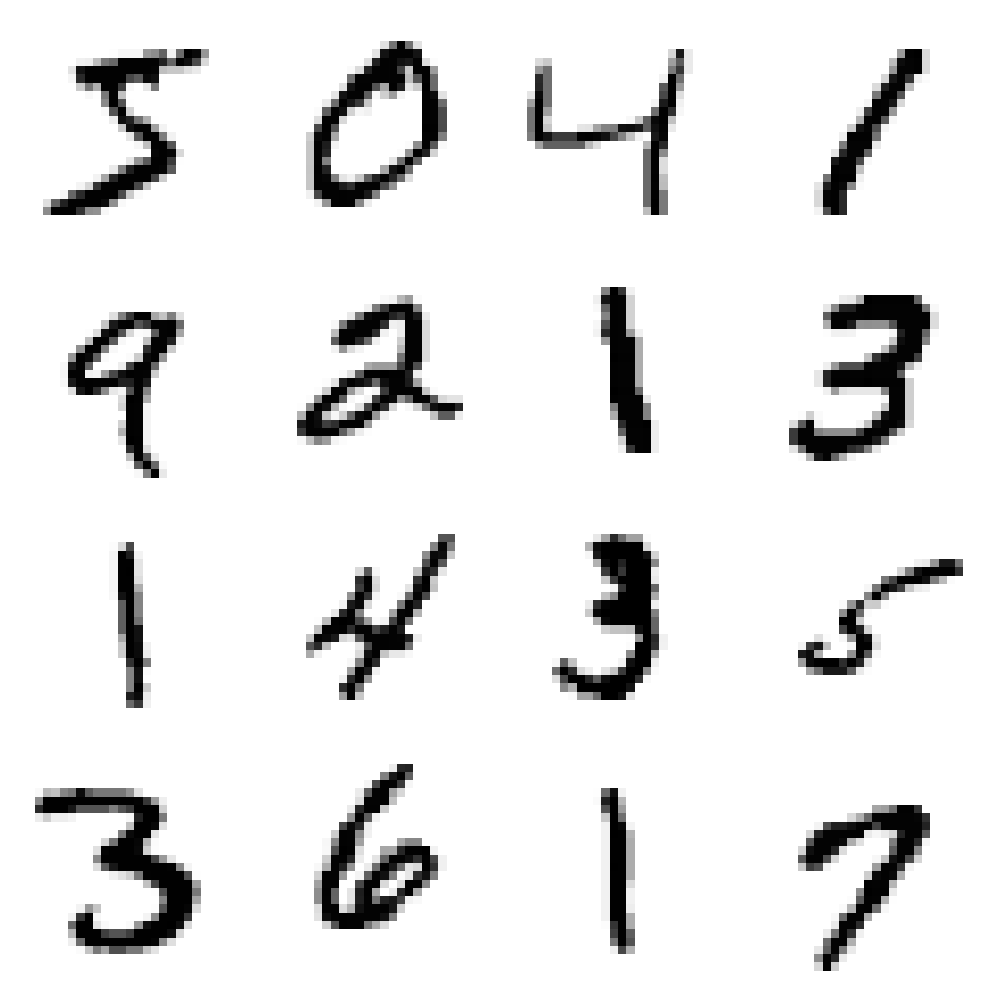

In [4]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the images and display them in the subplots
for i in range(16):
    # Assuming images are numpy arrays
    axes[i].imshow(x_train[i], cmap = 'Greys')  # Use cmap='gray' for grayscale images
    axes[i].axis('off')  # Turn off axis labels and ticks

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()

Use `tf.data` to batch and shuffle the dataset:

In [5]:
# Create a TensorFlow Dataset for training data, shuffle and batch it
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))  # Convert training data to a Dataset
train_ds = train_ds.shuffle(10000).batch(32)  # Shuffle with a buffer size of 10,000 and batch into groups of 32

# Create a TensorFlow Dataset for testing data and batch it
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)  # Batch test data into groups of 32

# Summary:
# - `train_ds`: Shuffled and batched training dataset for efficient model training.
# - `test_ds`: Batches test data for evaluation without shuffling.


Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [6]:
# Define input shape
input_shape = (28, 28, 1)

# Define input layer
input_layer = Input(shape=input_shape)

# Convolutional layer with activation
conv1 = Conv2D(32, 3, activation='relu')(input_layer)
drop1 = Dropout(0.75)(conv1)

# Flatten layer
flatten = Flatten()(drop1)

# Dense output layer with softmax activation
output = Dense(10, activation='softmax')(flatten)

# Create the model
model = Model(inputs=input_layer, outputs=output)

Choose an optimizer and loss function for training:

In [7]:
# Define the loss function for the model
# CategoricalCrossentropy is used for multi-class classification problems where labels are one-hot encoded
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Define the optimizer for training the model
# Adam is an adaptive optimization algorithm that combines the benefits of RMSProp and SGD
optimizer = tf.keras.optimizers.Adam()


Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [8]:
# Metric to track the average training loss
train_loss = tf.keras.metrics.Mean(name='train_loss')

# Metric to track the training accuracy (for one-hot encoded labels)
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

# Metric to track the average testing loss
test_loss = tf.keras.metrics.Mean(name='test_loss')

# Metric to track the testing accuracy (for one-hot encoded labels)
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')


Use `tf.GradientTape` to train the model:

In [9]:
# Define a single training step as a TensorFlow function for performance optimization
@tf.function
def train_step(images, labels):
    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Forward pass through the model
        # Set training=True to ensure layers like Dropout behave correctly during training
        predictions = model(images, training=True)
        # Compute the loss between predictions and true labels
        loss = loss_object(labels, predictions)

    # Compute gradients of the loss with respect to the model's trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradients to update the model parameters using the optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update training metrics
    train_loss(loss)  # Track the average training loss
    train_accuracy(labels, predictions)  # Track the training accuracy


Test the model:

In [13]:
# Define a single testing step as a TensorFlow function for performance optimization
@tf.function
def test_step(images, labels):
    # Perform a forward pass through the model in inference mode
    # Set training=False to ensure layers like Dropout behave correctly during inference
    predictions = model(images, training=False)
    # Compute the loss between predictions and true labels
    t_loss = loss_object(labels, predictions)

    # Update testing metrics
    test_loss(t_loss)  # Track the average testing loss
    test_accuracy(labels, predictions)  # Track the testing accuracy


In [14]:
# Define the number of epochs (full passes through the entire dataset during training)
EPOCHS = 5

# Explanation of an epoch:
# An epoch is one complete iteration where the model processes all training data once.
# During each epoch, the model updates its weights by learning from the data.

# Loop over the number of epochs
for epoch in range(EPOCHS):
    # Reset metrics at the start of each epoch to calculate fresh statistics
    train_loss.reset_state()  # Reset accumulated training loss
    train_accuracy.reset_state()  # Reset accumulated training accuracy
    test_loss.reset_state()  # Reset accumulated test loss
    test_accuracy.reset_state()  # Reset accumulated test accuracy

    # Training loop: iterate over all batches in the training dataset
    for images, labels in train_ds:
        train_step(images, labels)  # Perform a training step for the current batch

    # Testing loop: iterate over all batches in the testing dataset
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)  # Perform a test step for the current batch

    # Print the results for the current epoch, including training and testing performance
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '  # Average training loss for the epoch
        f'Accuracy: {train_accuracy.result() * 100}, '  # Training accuracy as a percentage
        f'Test Loss: {test_loss.result()}, '  # Average testing loss for the epoch
        f'Test Accuracy: {test_accuracy.result() * 100}'  # Testing accuracy as a percentage
    )



Epoch 1, Loss: 0.2546965777873993, Accuracy: 92.49333190917969, Test Loss: 0.10394839197397232, Test Accuracy: 96.93000030517578
Epoch 2, Loss: 0.13459564745426178, Accuracy: 95.88833618164062, Test Loss: 0.08040580153465271, Test Accuracy: 97.53999328613281
Epoch 3, Loss: 0.11397576332092285, Accuracy: 96.42166137695312, Test Loss: 0.07143037021160126, Test Accuracy: 97.77999877929688
Epoch 4, Loss: 0.10040494799613953, Accuracy: 96.85833740234375, Test Loss: 0.06717890501022339, Test Accuracy: 97.86000061035156
Epoch 5, Loss: 0.09127891808748245, Accuracy: 97.09666442871094, Test Loss: 0.06344352662563324, Test Accuracy: 98.05999755859375


The image classifier is now trained to ~98% accuracy on this dataset.

#Interpretability

###Imports

In [15]:
!pip install shap

In [16]:
import shap

import keras

##SHAP

Condition SHAP on part of the train set

In [17]:
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

shap_expectations = shap.DeepExplainer(model, background)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Test it out by asking it to explain the first ten test set values

Here, we can see that on the y axis there are 10 different samples as we wanted

On the x axis, we can see the ten different classes

The pink areas are the positive explanations - why this sample belongs to this class

The blue areas indicate pink areas being present elsewhere - negative explanations are a combination of positive explanations for all other classes

Note that this image's colours may skew depending on very strong explanations making others look dimmer. You can use the same function to plot individual images or a smaller set of images. This is shown below.

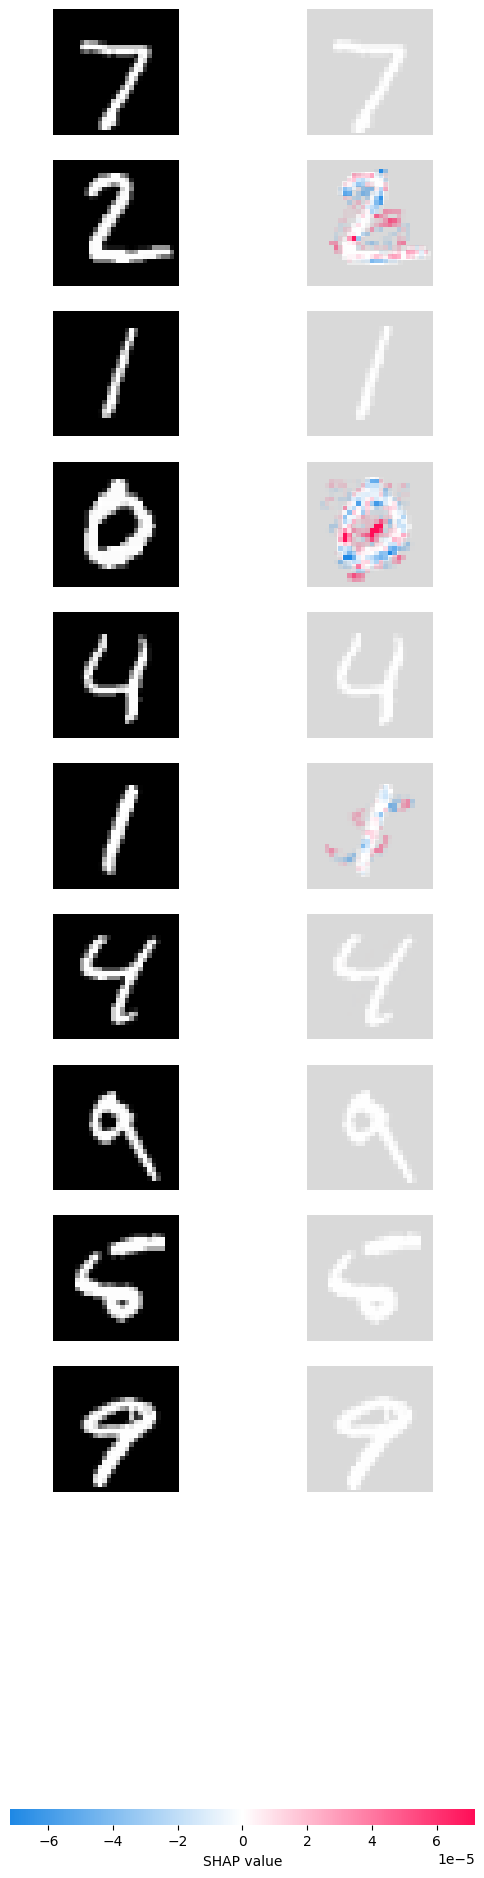

In [18]:
shap_values = shap_expectations.shap_values(x_test[0:10])

shap.image_plot(shap_values, x_test[0:10])

In [21]:
#Individual Plot
shap.image_plot(shap_values[0][0], x_test[wanted_wrongs[0]])

NameError: name 'y_pred' is not defined

#Exercises

###Exc 1:


We run interpretability on correct and incorrect samples to check different facets of the model.

Find and separate the correct answers from the incorrect ones

Let's find out where most of the wrong predictions and correct predictions are

Display the distribution of numbers in the corrects and wrongs

I expect some confusion between 1s and 7s because I used to have a lot of trouble with this as a kid, but surprisingly the model doesn't - let's check to see that it's doing ok

Use SHAP to visualise 10 correctly predicted 7s' explanations

Can you see if the distinguishing feature of 7s have been correctly selected here?

Use SHAP to visualise 10 correctly predicted 1s' explanations

What seems to be the distinguishing feature of the 1s as shown here?

The correct ones have a roughly even distribution but the incorrect predictions have a much more skewed distribution - what analysis can you perform here by looking at these?

What numbers seem like they're getting confused?

Let's see if there's any significant mispredictions happening

Plot the predicted numbers against the true labels to see if there are any systematic errors occuring here

In my model, 9s get misrepresented as 4s the most. It's an intuitive error, but let's see what the model is seeing

Use SHAP to visualise the errors on 10 of these numbers

Note - you may need to individually plot these to visualise the colours properly (select which picture you want in the shap values array and then in the x_test)

We need to find out if there are any alternative ways of writing numbers that the model struggles with - what numbers and corresponding styles would you recommend augmenting the dataset with? You can work with the person next to you to speed this up

###Exc 2:

Visualise filters

Preamble

In [ ]:
import keras

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

Find the name of the convolutional layer of the model we want to visualise

In [ ]:
# Our target layer: we will visualize the filters from this layer.
layer_name = "______"

layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

We need to construct an image to give to the filter visualiser so that it can maximises the filter activation -

Write a function that makes a random image with depth and height that can be passed to the filter visualiser - remember, the model has to be able to process this image

In [ ]:
def initialize_image(img_width, img_height, channels = 1):
    # We start from a gray image with some random noise



    return img

There needs to be some kind of hyperparameter tuning to ensure that the filters are coming out right - tune the iterations and the learning rate

In [ ]:
#Hyperparameters
iterations = ???
learning_rate = ???

#Which filter do you want to visualise?
filter_index = ???

img = initialize_image(28,28)
for iteration in range(iterations):
    loss, img = gradient_ascent_step(img, filter_index, learning_rate)


plt.imshow(img[0], cmap='Greys')
print(loss)

Great, now wrap it up into a function!

In [ ]:
def visualize_filter(filter_index, iterations=30, learning_rate=10):
    # We run gradient ascent for 20 steps
    img = initialize_image(28,28)



    return loss, img

Can you write a script that visualises all the filters in the neural network?

What do the filters look for in the images? Discuss with the person sitting next to you